In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

import cv2
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models, utils as vutils
from torchvision.transforms.functional import adjust_contrast

import clip
from tqdm import tqdm

from src import StyleNet, utils
from src.def_train import *
from src.meta_shape_priors import generate_meta_mask
from src.sam import init_sam_model, combine_with_foreground_mask
from src.two_class_prompt_template import *

In [2]:
normal_img_path = "./images/normal_image_ex1.png"
category = "wood"
defect = "scratch"

save_path = "./results"
os.makedirs(save_path, exist_ok=True)

img_width, img_height = 512, 512
lambda_tv, lambda_pdir, lambda_gdir, lambda_c, lambda_mclip = 2e-3, 9000, 500, 150, 1000
crop_size, num_crops = 128, 64
max_step, lr, thresh = 75, 5e-4, 0.7
seed = 77
use_fg_mask = False

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda


In [3]:
predictor = None
if use_fg_mask:
    predictor = init_sam_model(
        model_type="vit_b",
        checkpoint_path="./sam_vit_b_01ec64.pth"
    )

In [ ]:
print("Loading VGG and CLIP models...")
VGG = models.vgg19(pretrained=True).features.to(device).eval()
for p in VGG.parameters():
    p.requires_grad = False
clip_model, _ = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("Model loading done.")

In [5]:
print("Generating text embeddings...")

normal_phrases = [template_prompt.format(normal_prompt.format(category))
                    for template_prompt in template_level_prompts
                    for normal_prompt in state_level_normal_prompts]

abnormal_phrases = []
for template_prompt in template_level_prompts:
    for abnormal_prompt in state_level_abnormal_prompts + state_level_abnormality_specific_prompts:
        try:
            phrase = template_prompt.format(abnormal_prompt.format(category, defect))
        except TypeError:
            phrase = template_prompt.format(abnormal_prompt.format(category))
        abnormal_phrases.append(phrase)

with torch.no_grad():
    tokens = clip.tokenize(abnormal_phrases).to(device)
    text_features = clip_model.encode_text(tokens).mean(dim=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    tokens_src = clip.tokenize(normal_phrases).to(device)
    text_source = clip_model.encode_text(tokens_src).mean(dim=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)

print(f"  - text_features shape: {text_features.shape}")
print(f"  - text_source shape: {text_source.shape}")
print(f"normal_phrases: {len(normal_phrases)}, abnormal_phrases: {len(abnormal_phrases)}")

Generating text embeddings...
  - text_features shape: torch.Size([1, 512])
  - text_source shape: torch.Size([1, 512])
normal_phrases: 175, abnormal_phrases: 175


In [6]:
def numeric_key(fname):
    return int(os.path.splitext(fname)[0])

def img_normalize(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1, -1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1, -1, 1, 1)
    return (image - mean) / std

def clip_normalize(image):
    image = F.interpolate(image, size=224, mode='bicubic')
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device).view(1, -1, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device).view(1, -1, 1, 1)
    return (image - mean) / std

def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]
    return torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)

Loading normal image and extracting CLIP features...
  - content_image shape: torch.Size([1, 3, 512, 512])
  - source_features shape: torch.Size([1, 512])


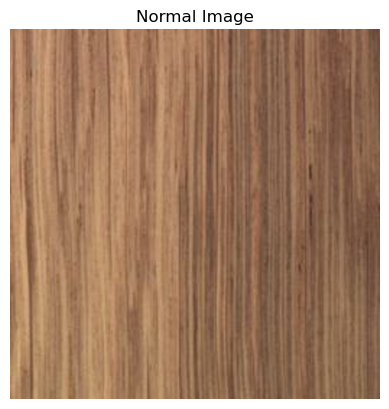

In [7]:
print("Loading normal image and extracting CLIP features...")
content_image = utils.load_image2(normal_img_path, img_height=img_height, img_width=img_width).to(device)

source_features = clip_model.encode_image(clip_normalize(content_image)).detach()
source_features /= source_features.norm(dim=-1, keepdim=True)

print(f"  - content_image shape: {content_image.shape}")
print(f"  - source_features shape: {source_features.shape}")

plt.imshow(content_image[0].permute(1, 2, 0).cpu())
plt.title("Normal Image")
plt.axis("off")
plt.show()

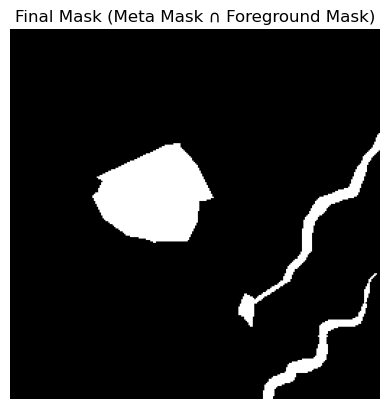

In [8]:
if use_fg_mask:
    mask = combine_with_foreground_mask(
        image_path=normal_img_path,
        predictor=predictor,
        m_max=5, 
        alpha=0.7
    )
else:
    mask = generate_meta_mask(
        W=img_width,
        H=img_height,
        m_max=5, 
        alpha=0.7
    )
    while mask.sum() == 0:
        mask = generate_meta_mask(
            W=img_width,
            H=img_height,
            m_max=5, 
            alpha=0.7
            )

plt.imshow(mask, cmap="gray")
plt.title("Final Mask (Meta Mask ∩ Foreground Mask)")
plt.axis("off")
plt.show()


In [9]:
import cv2
import numpy as np

def load_mask_as_array(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        raise FileNotFoundError(f"Mask not found: {mask_path}")

    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    return mask

In [10]:
mask_to_save = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
temp_mask_path = os.path.join(save_path, f"gen_mask.jpg")
cv2.imwrite(temp_mask_path, mask_to_save)

save_img_path = os.path.join(save_path, "gen_ano.jpg")

run_style_transfer(
    temp_mask_path, content_image,
    clip_model=clip_model, VGG=VGG, device=device,
    img_height=img_height, img_width=img_width,
    lambda_tv=lambda_tv, lambda_pdir=lambda_pdir,
    lambda_gdir=lambda_gdir, lambda_c=lambda_c,
    lambda_mclip=lambda_mclip,
    crop_size=crop_size, num_crops=num_crops,
    max_step=max_step, lr=lr, thresh=thresh,
    save_img_path=save_img_path,
    source_features=source_features,
    text_features=text_features,
    text_source=text_source
)

100%|██████████| 76/76 [00:12<00:00,  5.98it/s]


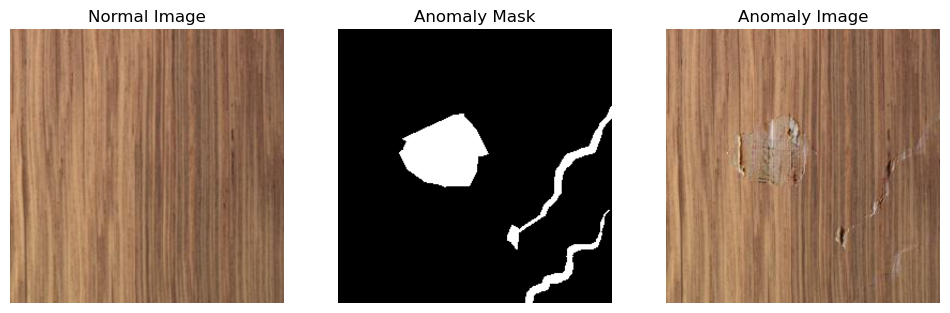

In [11]:
from PIL import Image

output_img = Image.open(save_img_path)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(content_image[0].permute(1, 2, 0).cpu())
plt.title("Normal Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Anomaly Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(output_img)
plt.title("Anomaly Image")
plt.axis("off")
plt.show()